## Part II: Traditional NLP Explorations

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import f_oneway
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob

In [2]:
# read in the data
data = pd.read_csv('archive/yelp_2020.csv')
data.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,J1LZjzbs5bFubvS135SD2g,5TE19zTjTIPq1HANACN7sw,dChRGpit9fM_kZK5pafNyA,5.0,1,0,1,Had a great big meal with family and we loved ...,2020-01-20 00:36:44,The Love,...,PA,19103.0,39.950656,-75.170899,4.0,618,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, American (New), Breakfast & Brunc...","{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ..."
1,ecMiAOFucDM3zwXYfY-Q6A,5Z8S9OsHWCnE8wbxk1poQQ,s3Q1J4XEVOBiZy9dYUpqpg,5.0,0,0,0,Many locations. All have lines so be prepared...,2020-02-16 22:52:13,Green Eggs Cafe,...,PA,19125.0,39.976974,-75.124114,3.5,93,1,"{'BusinessAcceptsCreditCards': 'False', 'HasTV...","Breakfast & Brunch, Restaurants","{'Monday': '9:0-15:0', 'Tuesday': '9:0-15:0', ..."
2,yuFQRhHo3z4TgE6drPXSgg,hcw7ndQKWGEH4P7BYAlG9w,JUlsvVAvZvGHWFfkKm0nlg,5.0,1,0,0,Compliments to the chef and to the rest of the...,2020-01-12 00:55:58,El Camino Real,...,PA,19123.0,39.967300,-75.140398,3.5,1014,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Mexican, Tex-Mex, Restaurants, Barbeque","{'Monday': '0:0-0:0', 'Tuesday': '11:0-23:0', ..."
3,Zdh0_HtE724MnohLOrB5Iw,OYaEBYLBrLY4mla8bOMbnA,9b0Mrvs6uJu2jJqet_Jwew,4.0,0,0,0,I decided to try this spot out -- and it didn'...,2020-01-15 19:29:25,Asia Nail 2 & Spa,...,PA,19146.0,39.938156,-75.172322,3.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Waxing, Nail Salons, Beauty & Spas, Health & M...","{'Monday': '9:30-20:0', 'Tuesday': '9:30-20:0'..."
4,y_XYEZk2Cin-q4N0czeaYw,_9VhEn9zaB-6txE3STNfLw,PYUI1OJVksGUbCrteU68bw,3.0,0,0,0,"First off, finding parking is atrocious. Your ...",2020-02-17 13:53:51,Bourbon & Branch,...,PA,19123.0,39.962070,-75.141040,4.0,392,1,"{'Alcohol': ""u'full_bar'"", 'BusinessParking': ...","Bars, American (Traditional), Breakfast & Brun...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


In [3]:
# print the shape of the data
print(data.shape)

# data cleaning
data.dropna(subset=['text', 'stars_x'], inplace=True)
data = data[['user_id', 'business_id', 'text', 'stars_x']]
data.rename(columns={'text': 'reviews', 'stars_x': 'rates'}, inplace=True)

# print the shape of the data again
print(data.shape)

(50203, 22)
(50203, 4)


In [4]:
# NLP preprocessing
def clean_text(text):
    # remove html tags
    text = re.sub(r'<.*?>', '', text)
    # remove the none-letter characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # change to lower case and strip white spaces
    text = text.lower().strip()
    return text

# 应用clean_text到评论数据
data['cleaned_reviews'] = data['reviews'].apply(clean_text)

In [5]:
# sentiment analysis
def get_sentiment(text):
    # use TextBlob to get the sentiment
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# add sentiment to the data
data['sentiment'] = data['cleaned_reviews'].apply(get_sentiment)

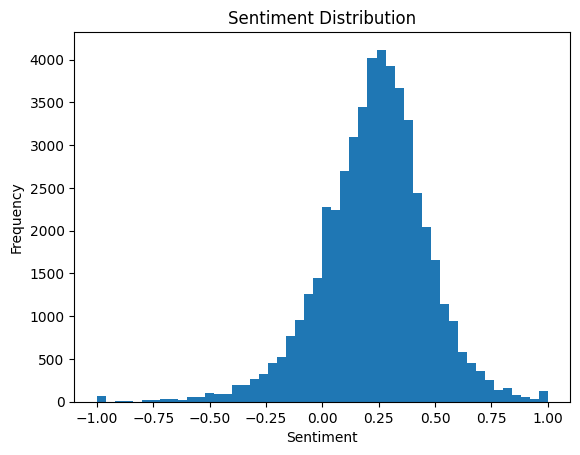

In [6]:
# plot the distribution of sentiment
plt.hist(data['sentiment'], bins=50)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

correlation between sentiment and rates: 0.644382730882733


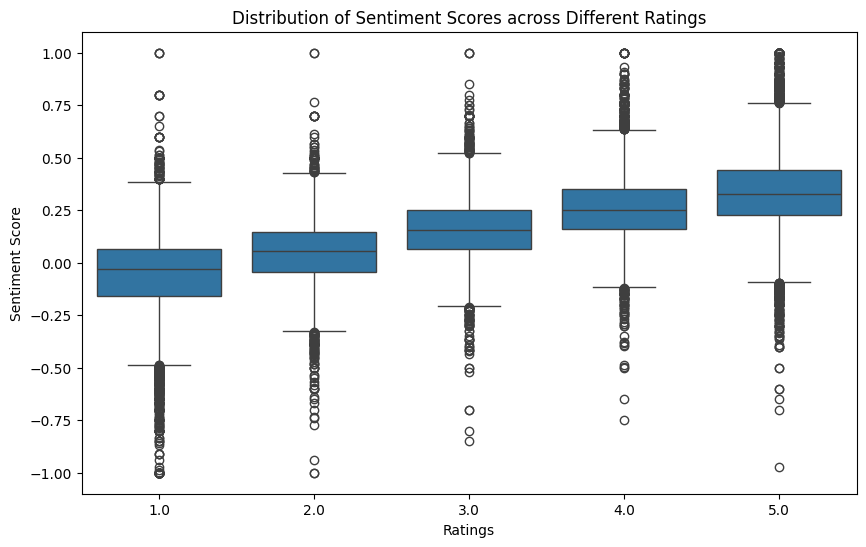

In [7]:
# correlation between sentiment and rates
correlation = data['sentiment'].corr(data['rates'])
print(f'correlation between sentiment and rates: {correlation}')

# Visualize sentiment distribution across different ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='rates', y='sentiment', data=data)
plt.xlabel('Ratings')
plt.ylabel('Sentiment Score')
plt.title('Distribution of Sentiment Scores across Different Ratings')
plt.show()

In [8]:
# Statistical inference to check if sentiment scores differ by ratings
anova_result = f_oneway(
    *[data[data['rates'] == rating]['sentiment'] for rating in data['rates'].unique()]
)
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 8970.488683440839, p-value: 0.0


In [9]:
# split the data into training and testing
X = data['sentiment'].values.reshape(-1, 1)
y = data['rates'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Squared Error: 1.3765900992829858
R^2: 0.39927379042979105


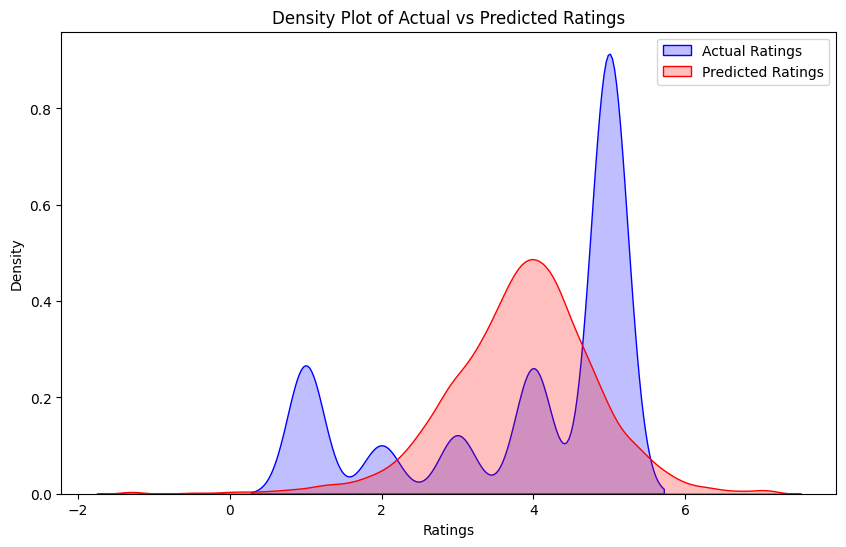

In [10]:
# regression model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')

# Visualize the prediction results using a density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Ratings', color='blue', fill=True)
sns.kdeplot(y_pred, label='Predicted Ratings', color='red', fill=True)
plt.xlabel('Ratings')
plt.ylabel('Density')
plt.title('Density Plot of Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [11]:
# Polynomial Regression model
poly = PolynomialFeatures(degree=3)  # Use a degree-6 polynomial
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

Mean Squared Error: 1.2299114083364515
R^2: 0.46328248414546336


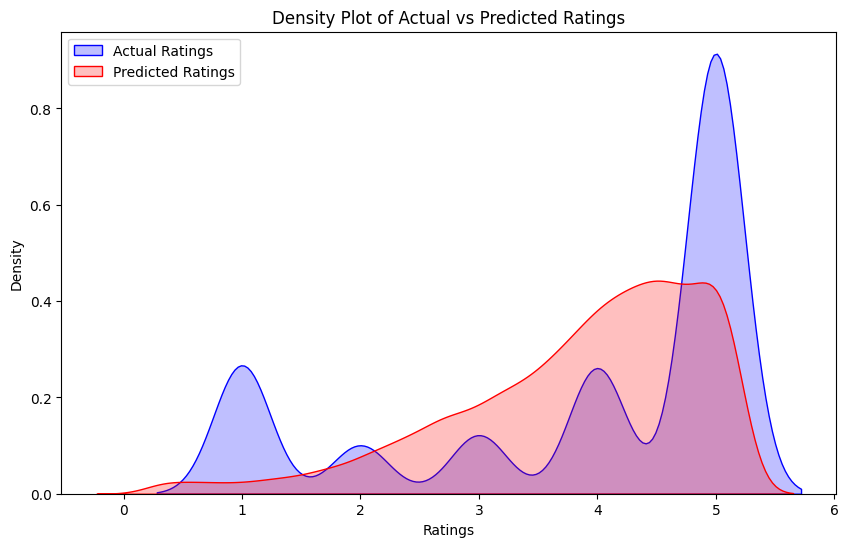

In [12]:
# regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# make predictions
y_pred = model.predict(X_test_poly)

# evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')

# Visualize the prediction results using a density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Ratings', color='blue', fill=True)
sns.kdeplot(y_pred, label='Predicted Ratings', color='red', fill=True)
plt.xlabel('Ratings')
plt.ylabel('Density')
plt.title('Density Plot of Actual vs Predicted Ratings')
plt.legend()
plt.show()

### NLP embedding